<a href="https://colab.research.google.com/github/DivyaSharma0795/Airbnb-Price-Prediction/blob/main/Explainable_Techniques_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #03
### Explainable Techniques 02
### Divya Sharma

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1zlu17hfg09EIHzdanRe9KFvIjd6Gwi2r?usp=sharing)

# Introduction

This notebook is an introduction to explainability techniques such as PDP, ICE, and ALE plots. These techniques help us understand the relationship between input features and model predictions.


### Overview
To do this, I will be using the [Calories Burnt](https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction) dataset from Kaggle, as it has a mix of categorical and numerical features, and the target variable is continuous, so it will be a good dataset to demonstrate these techniques.


# Step 0 - importinng necessary libraries

In [ ]:
!pip install alibi -q

In [ ]:
# Importing required libraries for reading data and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import kagglehub
import seaborn as sns

# Step 1 - Load Dataset and basic EDA

In [ ]:
# Download latest version
path = kagglehub.dataset_download("ruchikakumbhar/calories-burnt-prediction")

print("Path to dataset files:", path)
data = pd.read_csv(path + '/calories.csv')
data.sample(5)

100%|██████████| 236k/236k [00:00<00:00, 423kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ruchikakumbhar/calories-burnt-prediction/versions/1


,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
11950,14498304,male,33,201.0,103.0,20.0,98.0,40.4,108.0
9020,13285045,female,24,166.0,65.0,4.0,76.0,38.8,11.0
12282,15960246,male,21,165.0,70.0,12.0,103.0,40.1,59.0
2255,13131717,male,20,183.0,80.0,11.0,94.0,40.1,41.0
2442,12165950,female,39,156.0,55.0,15.0,95.0,39.9,78.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
data.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


Basic EDA shows that there are 6 features and 1 target variable. The target variable is continuous, and the features are a mix of categorical and numerical features. There are no missing values in the dataset, and there are 15000 observations.

# Step 2 - EDA
> Used github copilot here to generate the plot codes

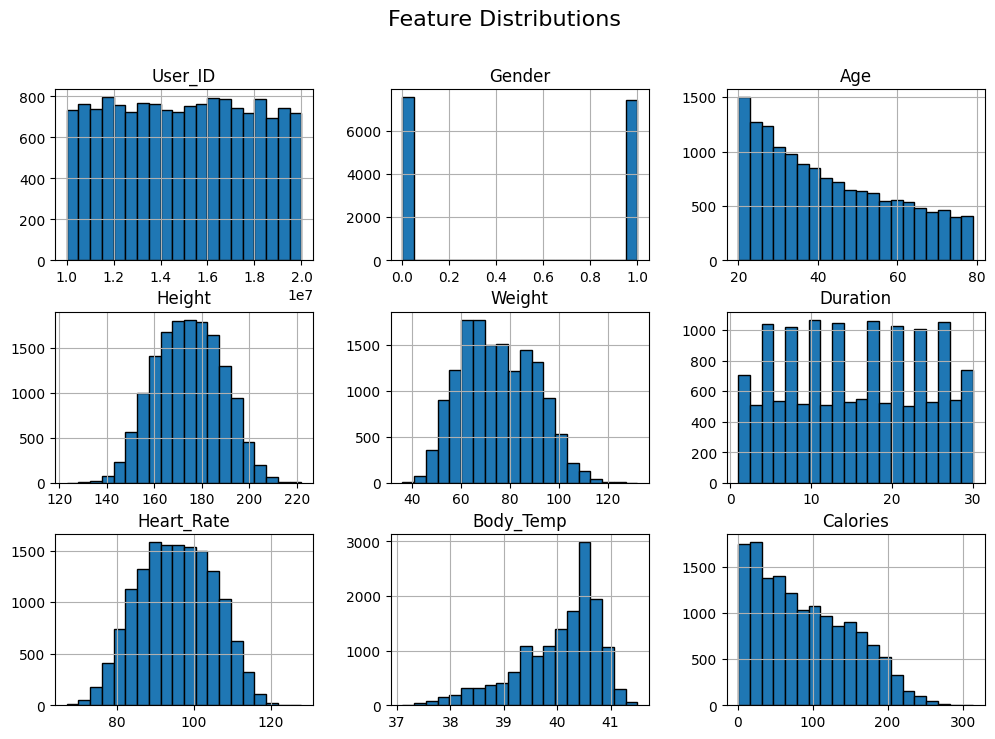

In [ ]:
data['Gender'] = data['Gender'].map({'male': 1, 'female': 0})
data.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

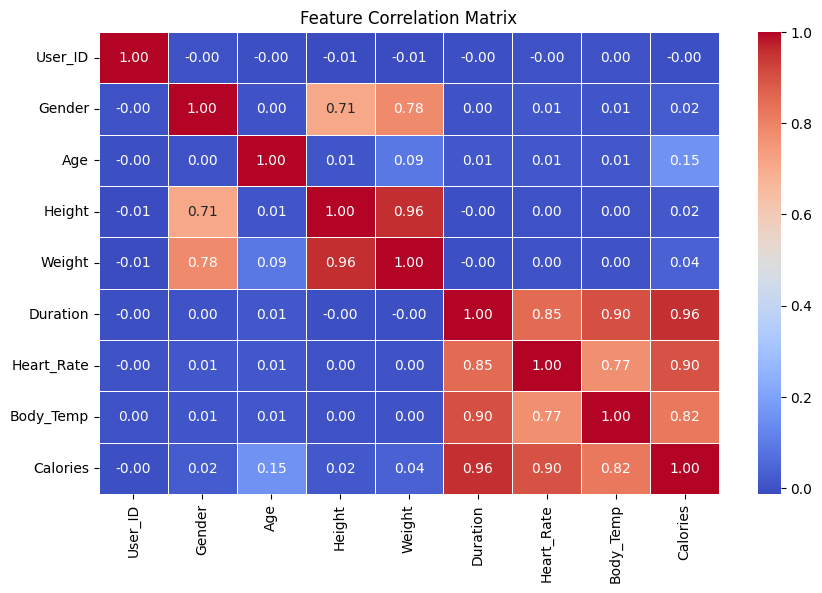

In [ ]:

# Compute correlation matrix
corr_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

There are some highly correlated features as seen in the plot above. To perform regression, we can remove one of the highly correlated features to avoid multicollinearity. Since Height and Weight are highly correlated, we can remove one of them. I will remove the `Weight` feature. Also, I will remove the `user_id` feature as it is not useful for the model.

In [ ]:
data.drop(['User_ID', 'Weight'], axis=1, inplace=True)

In [ ]:
data.sample(5)

,Gender,Age,Height,Duration,Heart_Rate,Body_Temp,Calories
3014,0,26,160.0,6.0,83.0,38.9,22.0
11717,0,52,158.0,14.0,99.0,40.2,81.0
4492,1,33,191.0,14.0,94.0,40.1,66.0
12680,1,71,179.0,19.0,89.0,40.6,103.0
9078,1,23,188.0,1.0,88.0,37.6,3.0


# Step 3 - Model Training

Using Random Forest to train the model, so that it can reveal non-linear relationships between the features and the target variable.
> Used github copilot here to generate the model training code

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


X = data[['Gender', 'Age', 'Height', 'Duration', 'Heart_Rate', 'Body_Temp']]
y = data["Calories"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to show the model output with residuals
output_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': y_test - y_pred
})

# Display the output DataFrame
print("Model Output Table:")
print(output_df)

# Display feature importances
print("\nFeature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

# Display evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Model Output Table:
       Actual  Predicted  Residual
11499   173.0     169.82      3.18
6475    189.0     186.43      2.57
13167    53.0      53.63     -0.63
862     161.0     157.20      3.80
5970    226.0     220.64      5.36
...       ...        ...       ...
6216    186.0     184.68      1.32
3585     53.0      53.99     -0.99
10023   120.0     119.89      0.11
14044    20.0      19.41      0.59
12965   214.0     216.56     -2.56

[3000 rows x 3 columns]

Feature Importances:
Gender: 0.007439518586866488
Age: 0.026653776562599762
Height: 0.0027392431450699974
Duration: 0.914009602468352
Heart_Rate: 0.0485706966858674
Body_Temp: 0.0005871625512443789

Evaluation Metrics:
Mean Squared Error: 8.336279136537035
R-squared: 0.9979344128200486


# Step 4 - PDP, ICE, and ALE Plots
> Used github copilot here to generate the plot codes

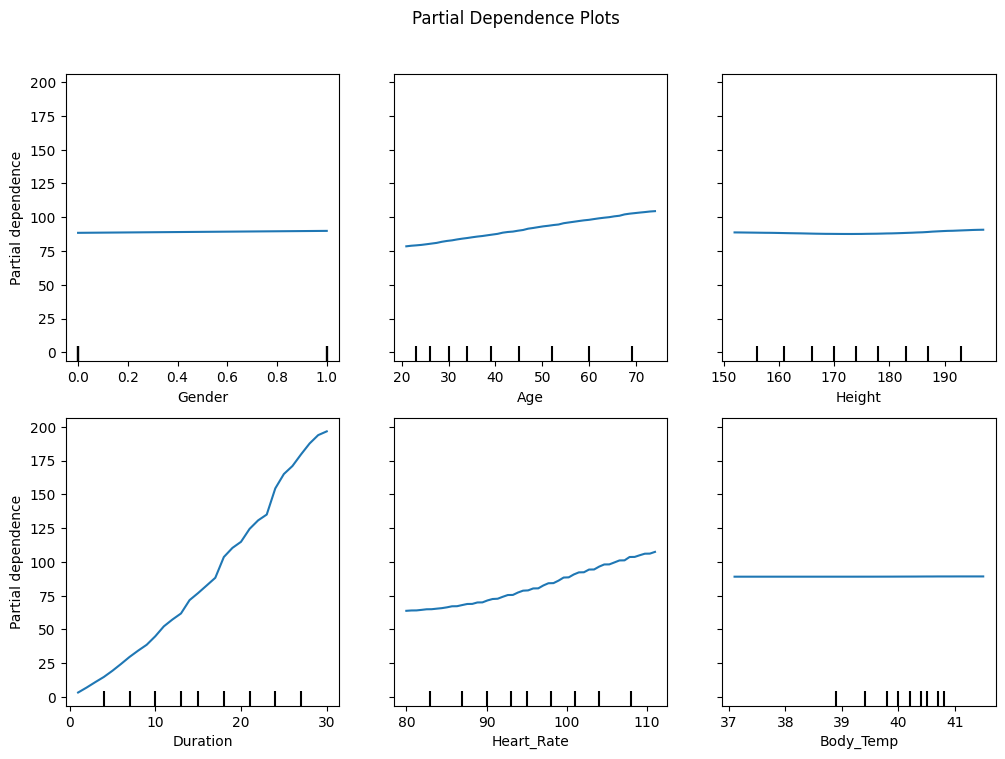

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Generate PDP plots for all features
features = X.columns.tolist()
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(rf_model, X_train, features, ax=ax, grid_resolution=50)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)
plt.show()

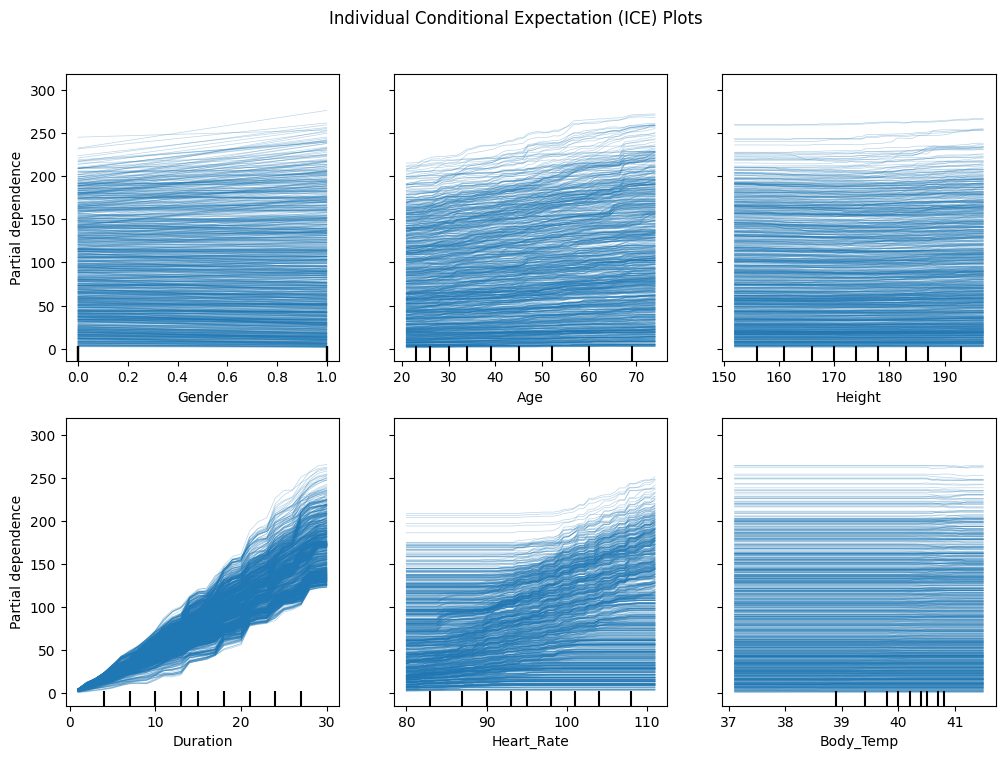

In [ ]:
# Generate ICE plots for all features
features = X.columns.tolist()
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(rf_model, X_train, features, kind='individual', ax=ax, grid_resolution=50)
plt.suptitle('Individual Conditional Expectation (ICE) Plots')
plt.subplots_adjust(top=0.9)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

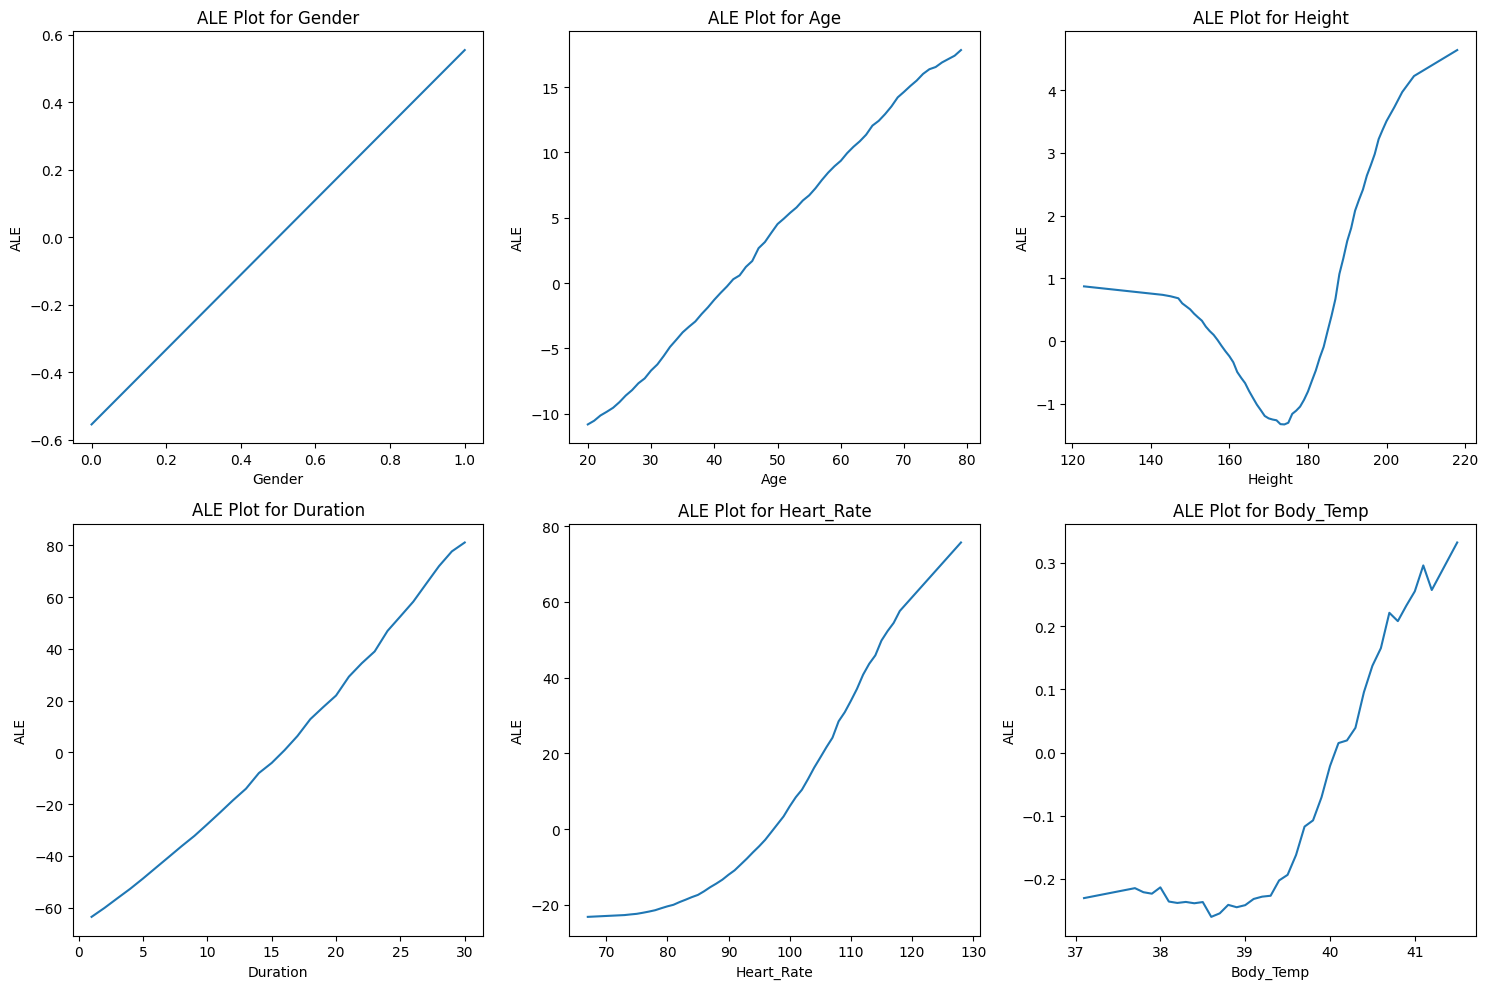

In [ ]:
from alibi.explainers import ALE

# Initialize ALE explainer
ale = ALE(rf_model.predict, feature_names=X.columns.tolist())

# Explain the model
explanation = ale.explain(X_train.values)

# Plot ALE plots for all features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, feature in enumerate(X.columns):
    ax = axes[i]
    ale_values = explanation.ale_values[i]
    feature_values = explanation.feature_values[i]
    ax.plot(feature_values, ale_values)
    ax.set_title(f'ALE Plot for {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('ALE')
plt.tight_layout()
plt.show()

# Discussion





# Conclusion


### Findings


### Summary
